<a href="https://colab.research.google.com/github/SoraFuji/audio-mora-inference/blob/main/notebook/inference_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cloning into 'audio-mora-inference'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 27 (delta 6), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (27/27), 874.17 KiB | 2.98 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Loaded labels: 100 classes
Loaded labels: 100 classes
Loading fine-tuned model…
Loading YAMNet…
→ YAMNet speech index=1, label=0,/m/09x0r,Speech
🔽 推論したい WAV をアップロードしてください（複数OK）


Saving ヒツジの鳴き声.wav to ヒツジの鳴き声.wav

===== Processing: ヒツジの鳴き声.wav =====

--- Segment 1 [0.0–1.4s] ---
▶ RAW (speech_prob=0.000)


  Top-5 Predictions:
         gya: 0.252
           e: 0.220
          ha: 0.216
          ne: 0.216
          te: 0.033


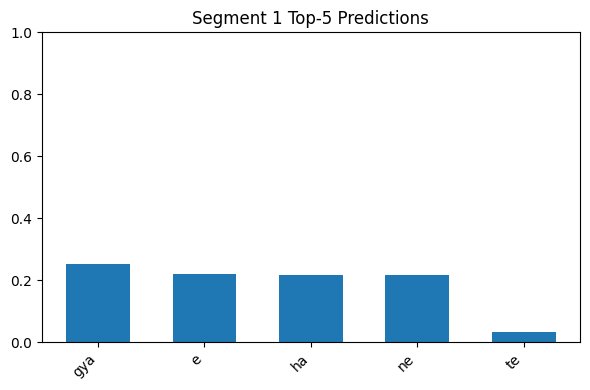

In [ ]:
# ───────────────────────────────────────────────────────────────────
# ===== GitHubリポジトリを Colab にコピー（clone）=====
!git clone https://github.com/SoraFuji/audio-mora-inference.git

# 1) 必要パッケージ（Colab想定）
!pip -q install webrtcvad tensorflow tensorflow-hub librosa soundfile matplotlib

# 2) インポート
import os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import librosa
import soundfile as sf
from google.colab import files
from IPython.display import Audio, display
import matplotlib.pyplot as plt

# 3) 定数
TARGET_SR        = 16000
WINDOW_SEC       = 5
SPEECH_THRESHOLD = 0.3
OUT_DIR          = "/content/output_audio_pipeline"
os.makedirs(OUT_DIR, exist_ok=True)

# 4) labels.txt 読み込み
LABELS_PATH = "/content/audio-mora-inference/labels.txt"

class_names = open(LABELS_PATH, "r", encoding="utf-8").read().splitlines()
print(f"Loaded labels: {len(class_names)} classes")


class_names = open(LABELS_PATH, "r", encoding="utf-8").read().splitlines()
print(f"Loaded labels: {len(class_names)} classes")

# 5) モデルをURLからダウンロードしてロード
MODEL_URL  = "https://github.com/SoraFuji/audio-mora-inference/releases/download/v1.0/finetuned_moraa_model.1.h5"
MODEL_PATH = "/content/finetuned_moraa_model.h5"

if MODEL_URL == "PASTE_MODEL_URL_HERE":
    raise ValueError("MODEL_URL をあなたの公開URLに差し替えてください。")

if not os.path.exists(MODEL_PATH):
    !wget -q -O {MODEL_PATH} "{MODEL_URL}"

print("Loading fine-tuned model…")
ft_model = tf.keras.models.load_model(MODEL_PATH, compile=False)

# 6) YAMNetロード
print("Loading YAMNet…")
yamnet = hub.load('https://tfhub.dev/google/yamnet/1')

# 7) Speech index取得
cm_path = yamnet.class_map_path().numpy().decode()
yamnet_labels = open(cm_path, 'r').read().splitlines()
speech_idx = next(i for i,lbl in enumerate(yamnet_labels) if 'speech' in lbl.lower())
print(f"→ YAMNet speech index={speech_idx}, label={yamnet_labels[speech_idx]}")

# 8) 埋め込み抽出 (mean/std/max → 3072)
def extract_embedding(y):
    wav = tf.convert_to_tensor(y, tf.float32)
    _, embs, _ = yamnet(wav)
    em = embs.numpy()
    return np.concatenate([em.mean(0), em.std(0), em.max(0)], axis=0)

# 9) 推論（WAVだけアップロード）
print("🔽 推論したい WAV をアップロードしてください（複数OK）")
uploaded = files.upload()

for fn in uploaded:
    if not fn.lower().endswith(".wav"):
        print(f"Skip (not wav): {fn}")
        continue

    print(f"\n===== Processing: {fn} =====")
    audio, _ = librosa.load(fn, sr=TARGET_SR, mono=True)

    total_sec = len(audio) / TARGET_SR
    n_seg     = int(np.ceil(total_sec / WINDOW_SEC))
    base      = os.path.splitext(os.path.basename(fn))[0]

    for i in range(n_seg):
        t0, t1 = i*WINDOW_SEC, min((i+1)*WINDOW_SEC, total_sec)
        s, e   = int(t0*TARGET_SR), int(t1*TARGET_SR)
        seg    = audio[s:e]

        path_raw = f"{OUT_DIR}/{base}_seg{i+1}_raw.wav"
        sf.write(path_raw, seg, TARGET_SR)

        scores, _, _ = yamnet(tf.convert_to_tensor(seg, tf.float32))
        avg_scores   = tf.reduce_mean(scores, axis=0).numpy()
        sp_prob      = float(avg_scores[speech_idx])

        if sp_prob > SPEECH_THRESHOLD:
            top5 = []
        else:
            emb  = extract_embedding(seg)[None, :]
            prob = ft_model.predict(emb, verbose=0)[0]
            top5 = [(class_names[j], float(prob[j]))
                    for j in prob.argsort()[-5:][::-1]]

        print(f"\n--- Segment {i+1} [{t0:.1f}–{t1:.1f}s] ---")
        print(f"▶ RAW (speech_prob={sp_prob:.3f})")
        display(Audio(path_raw, rate=TARGET_SR))

        if top5:
            print("  Top-5 Predictions:")
            for cls, sc in top5:
                print(f"    {cls:>8}: {sc:.3f}")
        else:
            print("  [Speech と判定 → 推論スキップ]")

        if top5:
            names = [cls for cls, _ in top5]
            scores_vals = [sc for _, sc in top5]
            x = np.arange(len(names))
            fig, ax = plt.subplots(figsize=(6,4))
            ax.bar(x, scores_vals, 0.6)
            ax.set_xticks(x)
            ax.set_xticklabels(names, rotation=45, ha='right')
            ax.set_ylim(0,1)
            ax.set_title(f"Segment {i+1} Top-5 Predictions")
            plt.tight_layout()
            plt.show()
